In [25]:
pip install torch torchvision  --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage
from tqdm import tqdm
import json


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" using device: {device}")

 using device: cuda


In [28]:
# Custom Dataset class with transformation
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['notumor', 'meningioma', 'pituitary', 'glioma']
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)
                    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Read image using PIL Image
        image = Image.open(img_path).convert('RGB')  # Ensure it has 3 channels
        
        if self.transform:
            image = self.transform(image)  # Apply transformation
        
        return image, label


In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


In [30]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(224 * 224, 1024)   # First layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 2048)        # Second layer with 2048 neurons
        self.fc3 = nn.Linear(2048, 1024)        # Third layer with 1024 neurons
        self.fc4 = nn.Linear(1024, 512)         # Fourth layer with 512 neurons
        self.fc5 = nn.Linear(512, 256)          # Fifth layer with 256 neurons
        self.fc6 = nn.Linear(256, 128)          # Sixth layer with 128 neurons
        self.fc7 = nn.Linear(128, 4)            # Output layer with 4 classes

    def forward(self, x):
        x = x.view(-1, 224 * 224)  # Flatten the image to match the input size
        x = torch.relu(self.fc1(x))  # ReLU activation after the first hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation after the second hidden layer
        x = torch.relu(self.fc3(x))  # ReLU activation after the third hidden layer
        x = torch.relu(self.fc4(x))  # ReLU activation after the fourth hidden layer
        x = torch.relu(self.fc5(x))  # ReLU activation after the fifth hidden layer
        x = torch.relu(self.fc6(x))  # ReLU activation after the sixth hidden layer
        x = self.fc7(x)              # Output layer (raw logits)
        return x



In [31]:
# Load the datasets
train_dataset = ImageDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=transform)
test_dataset = ImageDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=transform)

# Split the test data for validation
val_size = int(0.33 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)  # Increased batch size
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)



In [32]:
model = CustomNN().to(device)
# class_weights = torch.tensor([1.0, 1.0, 2.0, 1.0])
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [33]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.3)


In [34]:
print(model)

CustomNN(
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=4, bias=True)
)


In [35]:
evaluation_list = []

best_epoch = -1
best_test_f1 = -1.0
best_model_state_dict = None


In [36]:
num_epochs = 40

In [37]:
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_labels = []
    all_preds = []
    
    # Create the tqdm progress bar for the training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", ncols=100) as tepoch:
        for images, labels in tepoch:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            # Update the progress bar with the current loss and accuracy
            tepoch.set_postfix(loss=running_loss/len(all_preds), accuracy=correct_preds/total_preds)
    
    # Calculate training accuracy, F1 score, and training loss
    train_accuracy = correct_preds / total_preds
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    train_loss = running_loss / len(train_loader)  # Average loss per batch
    
    # Evaluate on the validation set
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0
    val_all_labels = []
    val_all_preds = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)
            
            val_all_labels.extend(labels.cpu().numpy())
            val_all_preds.extend(predicted.cpu().numpy())
    
    val_accuracy = val_correct_preds / val_total_preds
    val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted')
    val_loss = val_loss / len(val_loader)  # Average loss per batch
    
    # Adjust the learning rate based on the validation loss
    scheduler.step(val_loss)  # Reduce learning rate if validation loss doesn't improve
    
    # Evaluate on the test set
    test_loss = 0.0
    test_correct_preds = 0
    test_total_preds = 0
    test_all_labels = []
    test_all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            test_correct_preds += (predicted == labels).sum().item()
            test_total_preds += labels.size(0)
            
            test_all_labels.extend(labels.cpu().numpy())
            test_all_preds.extend(predicted.cpu().numpy())
    
    test_accuracy = test_correct_preds / test_total_preds
    test_f1 = f1_score(test_all_labels, test_all_preds, average='weighted')
    test_loss = test_loss / len(test_loader)  # Average loss per batch
    
    # Save the model with the best validation F1 score
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_model_state_dict = model.state_dict()  # Save model state dict
        best_epoch = epoch + 1

        # Optionally save the best model to file
        torch.save(best_model_state_dict, 'best_model.pth')

    # Store metrics in the evaluation list
    evaluation_metrics = {
        "Epoch": epoch + 1,
        "Training Accuracy": train_accuracy,
        "Training F1 Score": train_f1,
        "Training Loss": train_loss,
        "Validation Accuracy": val_accuracy,
        "Validation F1 Score": val_f1,
        "Validation Loss": val_loss,
        "Test Accuracy": test_accuracy,
        "Test F1 Score": test_f1,
        "Test Loss": test_loss
    }
    
    evaluation_list.append(evaluation_metrics)
    
    # Print the results in JSON format
    print(json.dumps(evaluation_metrics, indent=4))


Epoch 1/40: 100%|████████████████████| 90/90 [00:09<00:00,  9.42batch/s, accuracy=0.49, loss=0.0174]


{
    "Epoch": 1,
    "Training Accuracy": 0.4896708683473389,
    "Training F1 Score": 0.4727619229601276,
    "Training Loss": 1.101703088151084,
    "Validation Accuracy": 0.6226851851851852,
    "Validation F1 Score": 0.5619815411313148,
    "Validation Loss": 0.8570222684315273,
    "Test Accuracy": 0.590443686006826,
    "Test F1 Score": 0.5236037411350116,
    "Test Loss": 0.8940879872867039
}


Epoch 2/40: 100%|███████████████████| 90/90 [00:09<00:00,  9.04batch/s, accuracy=0.663, loss=0.0121]


{
    "Epoch": 2,
    "Training Accuracy": 0.6626400560224089,
    "Training F1 Score": 0.6406636320558975,
    "Training Loss": 0.765252310037613,
    "Validation Accuracy": 0.7384259259259259,
    "Validation F1 Score": 0.6641170997712448,
    "Validation Loss": 0.7031453592436654,
    "Test Accuracy": 0.7064846416382252,
    "Test F1 Score": 0.6172442422924288,
    "Test Loss": 0.7613142856529781
}


Epoch 3/40: 100%|███████████████████| 90/90 [00:09<00:00,  9.47batch/s, accuracy=0.685, loss=0.0106]


{
    "Epoch": 3,
    "Training Accuracy": 0.6853991596638656,
    "Training F1 Score": 0.6662684301256717,
    "Training Loss": 0.6756236596239937,
    "Validation Accuracy": 0.6944444444444444,
    "Validation F1 Score": 0.6553801947108399,
    "Validation Loss": 0.7824387039457049,
    "Test Accuracy": 0.6439135381114903,
    "Test F1 Score": 0.6084144087034508,
    "Test Loss": 0.8336326820509774
}


Epoch 4/40: 100%|██████████████████| 90/90 [00:09<00:00,  9.02batch/s, accuracy=0.716, loss=0.00929]


{
    "Epoch": 4,
    "Training Accuracy": 0.7163865546218487,
    "Training F1 Score": 0.6987307646560371,
    "Training Loss": 0.5898198596305317,
    "Validation Accuracy": 0.7430555555555556,
    "Validation F1 Score": 0.7180106844458697,
    "Validation Loss": 0.7710650435515812,
    "Test Accuracy": 0.6837315130830489,
    "Test F1 Score": 0.6530057774070311,
    "Test Loss": 0.7901480495929718
}


Epoch 5/40: 100%|███████████████████| 90/90 [00:09<00:00,  9.50batch/s, accuracy=0.751, loss=0.0084]


{
    "Epoch": 5,
    "Training Accuracy": 0.7514005602240896,
    "Training F1 Score": 0.7387559489924849,
    "Training Loss": 0.5334005441930559,
    "Validation Accuracy": 0.7824074074074074,
    "Validation F1 Score": 0.7465162214010647,
    "Validation Loss": 0.5482391629900251,
    "Test Accuracy": 0.7406143344709898,
    "Test F1 Score": 0.694893535845302,
    "Test Loss": 0.6111433186701366
}


Epoch 6/40: 100%|███████████████████| 90/90 [00:09<00:00,  9.56batch/s, accuracy=0.77, loss=0.00783]


{
    "Epoch": 6,
    "Training Accuracy": 0.7703081232492998,
    "Training F1 Score": 0.7601121881677992,
    "Training Loss": 0.49704852600892385,
    "Validation Accuracy": 0.7962962962962963,
    "Validation F1 Score": 0.7891467220540301,
    "Validation Loss": 0.5375505345208305,
    "Test Accuracy": 0.7224118316268487,
    "Test F1 Score": 0.7075833321369569,
    "Test Loss": 0.5963954478502274
}


Epoch 7/40: 100%|██████████████████| 90/90 [00:10<00:00,  8.82batch/s, accuracy=0.808, loss=0.00705]


{
    "Epoch": 7,
    "Training Accuracy": 0.8081232492997199,
    "Training F1 Score": 0.8006015242734644,
    "Training Loss": 0.44771201146973505,
    "Validation Accuracy": 0.8032407407407407,
    "Validation F1 Score": 0.7935961815976003,
    "Validation Loss": 0.48195397002356394,
    "Test Accuracy": 0.7463026166097838,
    "Test F1 Score": 0.730287339494431,
    "Test Loss": 0.544660285115242
}


Epoch 8/40: 100%|██████████████████| 90/90 [00:09<00:00,  9.51batch/s, accuracy=0.824, loss=0.00638]


{
    "Epoch": 8,
    "Training Accuracy": 0.8240546218487395,
    "Training F1 Score": 0.8195464329568648,
    "Training Loss": 0.4050428983238008,
    "Validation Accuracy": 0.7708333333333334,
    "Validation F1 Score": 0.7259010180168091,
    "Validation Loss": 0.6401013519082751,
    "Test Accuracy": 0.7622298065984073,
    "Test F1 Score": 0.7200513559622806,
    "Test Loss": 0.6045996014560971
}


Epoch 9/40: 100%|██████████████████| 90/90 [00:09<00:00,  9.24batch/s, accuracy=0.833, loss=0.00638]


{
    "Epoch": 9,
    "Training Accuracy": 0.8328081232492998,
    "Training F1 Score": 0.8281737261398334,
    "Training Loss": 0.4047430760330624,
    "Validation Accuracy": 0.8101851851851852,
    "Validation F1 Score": 0.8063253217794917,
    "Validation Loss": 0.6966010587556022,
    "Test Accuracy": 0.7383390216154722,
    "Test F1 Score": 0.7313033532996167,
    "Test Loss": 0.7158990353345871
}


Epoch 10/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.55batch/s, accuracy=0.866, loss=0.00535]


{
    "Epoch": 10,
    "Training Accuracy": 0.866421568627451,
    "Training F1 Score": 0.8636820698797304,
    "Training Loss": 0.3392304528090689,
    "Validation Accuracy": 0.8634259259259259,
    "Validation F1 Score": 0.8547444315729216,
    "Validation Loss": 0.41952974668570925,
    "Test Accuracy": 0.800910125142207,
    "Test F1 Score": 0.7863839316016694,
    "Test Loss": 0.4988683270556586
}


Epoch 11/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.67batch/s, accuracy=0.883, loss=0.00483]


{
    "Epoch": 11,
    "Training Accuracy": 0.8834033613445378,
    "Training F1 Score": 0.8811894032305457,
    "Training Loss": 0.3067097909748554,
    "Validation Accuracy": 0.8495370370370371,
    "Validation F1 Score": 0.8466693949898285,
    "Validation Loss": 0.5112997144460678,
    "Test Accuracy": 0.8122866894197952,
    "Test F1 Score": 0.806103362085708,
    "Test Loss": 0.49959349845136913
}


Epoch 12/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.28batch/s, accuracy=0.895, loss=0.00426]


{
    "Epoch": 12,
    "Training Accuracy": 0.8949579831932774,
    "Training F1 Score": 0.8934118287650016,
    "Training Loss": 0.270474845253759,
    "Validation Accuracy": 0.8263888888888888,
    "Validation F1 Score": 0.8191700348812105,
    "Validation Loss": 0.6527308779103416,
    "Test Accuracy": 0.7747440273037542,
    "Test F1 Score": 0.7636845088944211,
    "Test Loss": 0.6074617803096771
}


Epoch 13/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.64batch/s, accuracy=0.906, loss=0.00399]


{
    "Epoch": 13,
    "Training Accuracy": 0.905812324929972,
    "Training F1 Score": 0.9047274867385957,
    "Training Loss": 0.25325540668434565,
    "Validation Accuracy": 0.8587962962962963,
    "Validation F1 Score": 0.8468420502125087,
    "Validation Loss": 0.5024668851069042,
    "Test Accuracy": 0.800910125142207,
    "Test F1 Score": 0.7746402705634833,
    "Test Loss": 0.4861475165401186
}


Epoch 14/40: 100%|██████████████████| 90/90 [00:09<00:00,  9.68batch/s, accuracy=0.91, loss=0.00376]


{
    "Epoch": 14,
    "Training Accuracy": 0.9103641456582633,
    "Training F1 Score": 0.9092396415707976,
    "Training Loss": 0.23872584427396457,
    "Validation Accuracy": 0.875,
    "Validation F1 Score": 0.8751757485212452,
    "Validation Loss": 0.5210257066147668,
    "Test Accuracy": 0.8361774744027304,
    "Test F1 Score": 0.8374916000620106,
    "Test Loss": 0.5066553673573903
}


Epoch 15/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.52batch/s, accuracy=0.948, loss=0.00225]


{
    "Epoch": 15,
    "Training Accuracy": 0.9481792717086834,
    "Training F1 Score": 0.9477902670258422,
    "Training Loss": 0.14286992193924056,
    "Validation Accuracy": 0.9189814814814815,
    "Validation F1 Score": 0.9193902235568902,
    "Validation Loss": 0.37582351905958994,
    "Test Accuracy": 0.8816837315130831,
    "Test F1 Score": 0.8807384312200279,
    "Test Loss": 0.2934842162898609
}


Epoch 16/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.80batch/s, accuracy=0.958, loss=0.00169]


{
    "Epoch": 16,
    "Training Accuracy": 0.9576330532212886,
    "Training F1 Score": 0.9575495728394725,
    "Training Loss": 0.10714313884576161,
    "Validation Accuracy": 0.9259259259259259,
    "Validation F1 Score": 0.9251541389821545,
    "Validation Loss": 0.42117844096251894,
    "Test Accuracy": 0.9078498293515358,
    "Test F1 Score": 0.9060784438985948,
    "Test Loss": 0.27552695625594686
}


Epoch 17/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.19batch/s, accuracy=0.967, loss=0.00142]


{
    "Epoch": 17,
    "Training Accuracy": 0.96656162464986,
    "Training F1 Score": 0.966537971250114,
    "Training Loss": 0.0904087632894516,
    "Validation Accuracy": 0.9212962962962963,
    "Validation F1 Score": 0.9210970004373109,
    "Validation Loss": 0.43242207169532776,
    "Test Accuracy": 0.8862343572241184,
    "Test F1 Score": 0.8854544823567938,
    "Test Loss": 0.3047303424349853
}


Epoch 18/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.00batch/s, accuracy=0.966, loss=0.00129]


{
    "Epoch": 18,
    "Training Accuracy": 0.9658613445378151,
    "Training F1 Score": 0.9659000219685898,
    "Training Loss": 0.08216263106506731,
    "Validation Accuracy": 0.9236111111111112,
    "Validation F1 Score": 0.9231431241479194,
    "Validation Loss": 0.557463319173881,
    "Test Accuracy": 0.8862343572241184,
    "Test F1 Score": 0.8841134860121648,
    "Test Loss": 0.3459352361304419
}


Epoch 19/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.37batch/s, accuracy=0.975, loss=0.00106]


{
    "Epoch": 19,
    "Training Accuracy": 0.9746148459383753,
    "Training F1 Score": 0.9745892386357297,
    "Training Loss": 0.06708454106830888,
    "Validation Accuracy": 0.9212962962962963,
    "Validation F1 Score": 0.9208353591466503,
    "Validation Loss": 0.5403646550008229,
    "Test Accuracy": 0.8987485779294653,
    "Test F1 Score": 0.8978796268594517,
    "Test Loss": 0.36578277019517763
}


Epoch 20/40: 100%|████████████████| 90/90 [00:09<00:00,  9.10batch/s, accuracy=0.982, loss=0.000785]


{
    "Epoch": 20,
    "Training Accuracy": 0.9816176470588235,
    "Training F1 Score": 0.9816346141265344,
    "Training Loss": 0.04981050801256465,
    "Validation Accuracy": 0.9351851851851852,
    "Validation F1 Score": 0.9351848332137586,
    "Validation Loss": 0.539467351777213,
    "Test Accuracy": 0.9180887372013652,
    "Test F1 Score": 0.9178240710004685,
    "Test Loss": 0.3176848978868553
}


Epoch 21/40: 100%|████████████████| 90/90 [00:09<00:00,  9.53batch/s, accuracy=0.987, loss=0.000539]


{
    "Epoch": 21,
    "Training Accuracy": 0.9870448179271709,
    "Training F1 Score": 0.98706355556248,
    "Training Loss": 0.03420675101483034,
    "Validation Accuracy": 0.9375,
    "Validation F1 Score": 0.9374150632747523,
    "Validation Loss": 0.561094377722059,
    "Test Accuracy": 0.9215017064846417,
    "Test F1 Score": 0.9212116250084149,
    "Test Loss": 0.33109811853085247
}


Epoch 22/40: 100%|████████████████| 90/90 [00:09<00:00,  9.24batch/s, accuracy=0.989, loss=0.000455]


{
    "Epoch": 22,
    "Training Accuracy": 0.9893207282913166,
    "Training F1 Score": 0.9893305533021053,
    "Training Loss": 0.028891199333075848,
    "Validation Accuracy": 0.9351851851851852,
    "Validation F1 Score": 0.9350864359641002,
    "Validation Loss": 0.5883544364145824,
    "Test Accuracy": 0.9203640500568828,
    "Test F1 Score": 0.9201483394657035,
    "Test Loss": 0.35172675071018084
}


Epoch 23/40: 100%|████████████████| 90/90 [00:09<00:00,  9.36batch/s, accuracy=0.992, loss=0.000366]


{
    "Epoch": 23,
    "Training Accuracy": 0.9915966386554622,
    "Training F1 Score": 0.9916148252841605,
    "Training Loss": 0.023229103571631844,
    "Validation Accuracy": 0.9375,
    "Validation F1 Score": 0.9372623254681337,
    "Validation Loss": 0.6382777201277869,
    "Test Accuracy": 0.9135381114903299,
    "Test F1 Score": 0.9127943190285485,
    "Test Loss": 0.43666855671576094
}


Epoch 24/40: 100%|████████████████| 90/90 [00:09<00:00,  9.47batch/s, accuracy=0.994, loss=0.000304]


{
    "Epoch": 24,
    "Training Accuracy": 0.9940476190476191,
    "Training F1 Score": 0.9940507267920738,
    "Training Loss": 0.0193108400523973,
    "Validation Accuracy": 0.9375,
    "Validation F1 Score": 0.9374150632747523,
    "Validation Loss": 0.6349565535783768,
    "Test Accuracy": 0.9215017064846417,
    "Test F1 Score": 0.9212569599676829,
    "Test Loss": 0.38161695855004446
}


Epoch 25/40: 100%|█████████████████| 90/90 [00:10<00:00,  8.83batch/s, accuracy=0.996, loss=0.00026]


{
    "Epoch": 25,
    "Training Accuracy": 0.9956232492997199,
    "Training F1 Score": 0.9956275892522106,
    "Training Loss": 0.016473618555270755,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6474678537675312,
    "Test Accuracy": 0.9226393629124005,
    "Test F1 Score": 0.9224028261141429,
    "Test Loss": 0.3886775416987283
}


Epoch 26/40: 100%|████████████████| 90/90 [00:09<00:00,  9.56batch/s, accuracy=0.995, loss=0.000249]


{
    "Epoch": 26,
    "Training Accuracy": 0.9954481792717087,
    "Training F1 Score": 0.9954524008603215,
    "Training Loss": 0.015795513713965193,
    "Validation Accuracy": 0.9351851851851852,
    "Validation F1 Score": 0.9350864359641002,
    "Validation Loss": 0.6670730986765453,
    "Test Accuracy": 0.9169510807736063,
    "Test F1 Score": 0.9166384112070723,
    "Test Loss": 0.4071158447435924
}


Epoch 27/40: 100%|████████████████| 90/90 [00:09<00:00,  9.63batch/s, accuracy=0.995, loss=0.000239]


{
    "Epoch": 27,
    "Training Accuracy": 0.9952731092436975,
    "Training F1 Score": 0.9952770720771138,
    "Training Loss": 0.015159337571822107,
    "Validation Accuracy": 0.9375,
    "Validation F1 Score": 0.9374150632747523,
    "Validation Loss": 0.6712292858532497,
    "Test Accuracy": 0.9226393629124005,
    "Test F1 Score": 0.9224028261141429,
    "Test Loss": 0.4115760289132595
}


Epoch 28/40: 100%|████████████████| 90/90 [00:09<00:00,  9.09batch/s, accuracy=0.996, loss=0.000203]


{
    "Epoch": 28,
    "Training Accuracy": 0.9963235294117647,
    "Training F1 Score": 0.9963260754502034,
    "Training Loss": 0.012902896176011482,
    "Validation Accuracy": 0.9375,
    "Validation F1 Score": 0.9374150632747523,
    "Validation Loss": 0.6720976403781346,
    "Test Accuracy": 0.9249146757679181,
    "Test F1 Score": 0.9246812502503049,
    "Test Loss": 0.41316802107862066
}


Epoch 29/40: 100%|████████████████| 90/90 [00:09<00:00,  9.41batch/s, accuracy=0.996, loss=0.000197]


{
    "Epoch": 29,
    "Training Accuracy": 0.9963235294117647,
    "Training F1 Score": 0.9963254714910309,
    "Training Loss": 0.012477117802417424,
    "Validation Accuracy": 0.9375,
    "Validation F1 Score": 0.9374150632747523,
    "Validation Loss": 0.6757372234548841,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.41600440070033073
}


Epoch 30/40: 100%|████████████████| 90/90 [00:09<00:00,  9.17batch/s, accuracy=0.997, loss=0.000191]


{
    "Epoch": 30,
    "Training Accuracy": 0.9971988795518207,
    "Training F1 Score": 0.9972000344916966,
    "Training Loss": 0.012120691168173733,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6798641213348934,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.4178363819207464
}


Epoch 31/40: 100%|████████████████| 90/90 [00:09<00:00,  9.61batch/s, accuracy=0.998, loss=0.000186]


{
    "Epoch": 31,
    "Training Accuracy": 0.9977240896358543,
    "Training F1 Score": 0.9977253121621874,
    "Training Loss": 0.01178448201648684,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6839396357536316,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235295469407137,
    "Test Loss": 0.4220519406454904
}


Epoch 32/40: 100%|████████████████| 90/90 [00:09<00:00,  9.60batch/s, accuracy=0.997, loss=0.000181]


{
    "Epoch": 32,
    "Training Accuracy": 0.9971988795518207,
    "Training F1 Score": 0.9971994099059872,
    "Training Loss": 0.011467723990143794,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6865698780332293,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.4220245118652071
}


Epoch 33/40: 100%|████████████████| 90/90 [00:09<00:00,  9.00batch/s, accuracy=0.997, loss=0.000176]


{
    "Epoch": 33,
    "Training Accuracy": 0.9973739495798319,
    "Training F1 Score": 0.9973749189721004,
    "Training Loss": 0.011179948365800859,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6889897095305579,
    "Test Accuracy": 0.9226393629124005,
    "Test F1 Score": 0.9223974245816194,
    "Test Loss": 0.4233702128486974
}


Epoch 34/40: 100%|████████████████| 90/90 [00:09<00:00,  9.42batch/s, accuracy=0.997, loss=0.000179]


{
    "Epoch": 34,
    "Training Accuracy": 0.9973739495798319,
    "Training F1 Score": 0.9973752300368943,
    "Training Loss": 0.011354228636870781,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.689816089613097,
    "Test Accuracy": 0.9226393629124005,
    "Test F1 Score": 0.9223974245816194,
    "Test Loss": 0.42416003718972206
}


Epoch 35/40: 100%|████████████████| 90/90 [00:09<00:00,  9.67batch/s, accuracy=0.998, loss=0.000173]


{
    "Epoch": 35,
    "Training Accuracy": 0.9975490196078431,
    "Training F1 Score": 0.9975498015011075,
    "Training Loss": 0.010958812469875233,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6916928631918771,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.42605045969997135
}


Epoch 36/40: 100%|████████████████| 90/90 [00:09<00:00,  9.41batch/s, accuracy=0.998, loss=0.000171]


{
    "Epoch": 36,
    "Training Accuracy": 0.9977240896358543,
    "Training F1 Score": 0.9977249982288736,
    "Training Loss": 0.010822557984243353,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.692202736224447,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.4263974795384066
}


Epoch 37/40: 100%|█████████████████| 90/90 [00:09<00:00,  9.57batch/s, accuracy=0.998, loss=0.00017]


{
    "Epoch": 37,
    "Training Accuracy": 0.9977240896358543,
    "Training F1 Score": 0.9977249982288736,
    "Training Loss": 0.010790070408256724,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6927140610558646,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.4269161415951593
}


Epoch 38/40: 100%|████████████████| 90/90 [00:10<00:00,  8.96batch/s, accuracy=0.998, loss=0.000171]


{
    "Epoch": 38,
    "Training Accuracy": 0.9977240896358543,
    "Training F1 Score": 0.9977249982288736,
    "Training Loss": 0.010848123395893102,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6934258107628141,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.4272461517580918
}


Epoch 39/40: 100%|████████████████| 90/90 [00:09<00:00,  9.41batch/s, accuracy=0.998, loss=0.000169]


{
    "Epoch": 39,
    "Training Accuracy": 0.9977240896358543,
    "Training F1 Score": 0.9977249982288736,
    "Training Loss": 0.010713839704274303,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.693852675812585,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.42760127410292625
}


Epoch 40/40: 100%|████████████████| 90/90 [00:09<00:00,  9.63batch/s, accuracy=0.998, loss=0.000168]


{
    "Epoch": 40,
    "Training Accuracy": 0.9977240896358543,
    "Training F1 Score": 0.9977249982288736,
    "Training Loss": 0.01065509581401582,
    "Validation Accuracy": 0.9398148148148148,
    "Validation F1 Score": 0.9397385935760235,
    "Validation Loss": 0.6940222127096993,
    "Test Accuracy": 0.9237770193401593,
    "Test F1 Score": 0.9235399490060937,
    "Test Loss": 0.4277535660990647
}



Training Results:
Training Accuracy: 0.9967
Training F1 Score: 0.9967
Training Loss: 0.0123


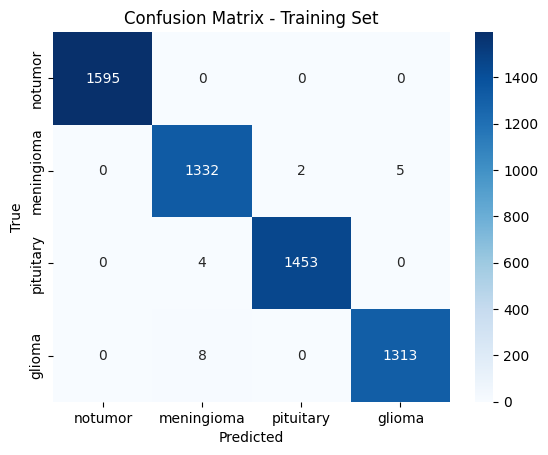


Final Test Results (Blind Test):
Test Accuracy: 0.9249
Test F1 Score: 0.9247
Test Loss: 0.4132


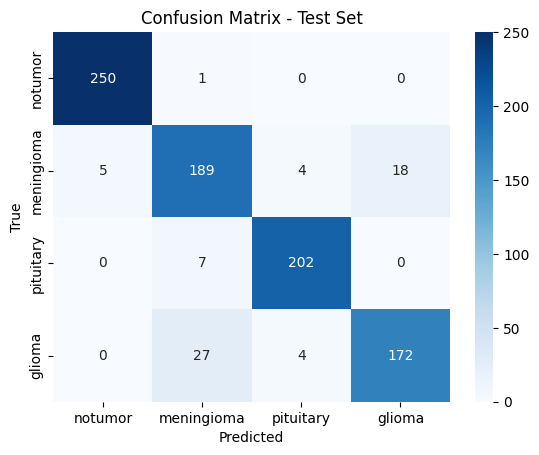

Confusion matrix plots have been saved and displayed successfully.


In [38]:
best_model = CustomNN().to(device)  # Replace with your actual model class
best_model.load_state_dict(torch.load('best_model.pth', weights_only=True))
best_model.to(device)  # Move the model to the correct device (GPU/CPU)
best_model.eval()  # Set the model to evaluation mode

# Function to compute and plot confusion matrix
def plot_confusion_matrix(labels, preds, title='Confusion Matrix', filename=None):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['notumor', 'meningioma', 'pituitary', 'glioma'], 
                yticklabels=['notumor', 'meningioma', 'pituitary', 'glioma'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    
    # Save the plot as a high-quality PNG file
    if filename:
        plt.savefig(filename, dpi=300)  # Save with high quality (300 dpi)
    
    # Display the plot
    plt.show()

# Evaluate on the training set (for evaluation purposes)
train_correct_preds = 0
train_total_preds = 0
train_all_labels = []
train_all_preds = []

train_loss = 0.0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = best_model(images)
        loss = criterion(outputs, labels)  # Calculate loss for training set
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        train_correct_preds += (predicted == labels).sum().item()
        train_total_preds += labels.size(0)
        
        train_all_labels.extend(labels.cpu().numpy())  # Move to CPU before numpy
        train_all_preds.extend(predicted.cpu().numpy())  # Move to CPU before numpy

# Calculate accuracy, F1 score, and average training loss
train_accuracy = train_correct_preds / train_total_preds
train_f1 = f1_score(train_all_labels, train_all_preds, average='weighted')
train_loss = train_loss / len(train_loader)  # Average loss per batch

# Print the training results
print(f"\nTraining Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Plot confusion matrix for the training set and save it
plot_confusion_matrix(train_all_labels, train_all_preds, title="Confusion Matrix - Training Set", filename='confusion_matrix_train.png')

# Evaluate on the test set
test_correct_preds = 0
test_total_preds = 0
test_all_labels = []
test_all_preds = []

test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = best_model(images)
        loss = criterion(outputs, labels)  # Calculate loss for test set
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        test_correct_preds += (predicted == labels).sum().item()
        test_total_preds += labels.size(0)
        
        test_all_labels.extend(labels.cpu().numpy())  # Move to CPU before numpy
        test_all_preds.extend(predicted.cpu().numpy())  # Move to CPU before numpy

# Calculate accuracy, F1 score, and average test loss
test_accuracy = test_correct_preds / test_total_preds
test_f1 = f1_score(test_all_labels, test_all_preds, average='weighted')
test_loss = test_loss / len(test_loader)  # Average loss per batch

# Print the final test results
print(f"\nFinal Test Results (Blind Test):")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot confusion matrix for the test set and save it
plot_confusion_matrix(test_all_labels, test_all_preds, title="Confusion Matrix - Test Set", filename='confusion_matrix_test.png')

# Print confirmation
print("Confusion matrix plots have been saved and displayed successfully.")



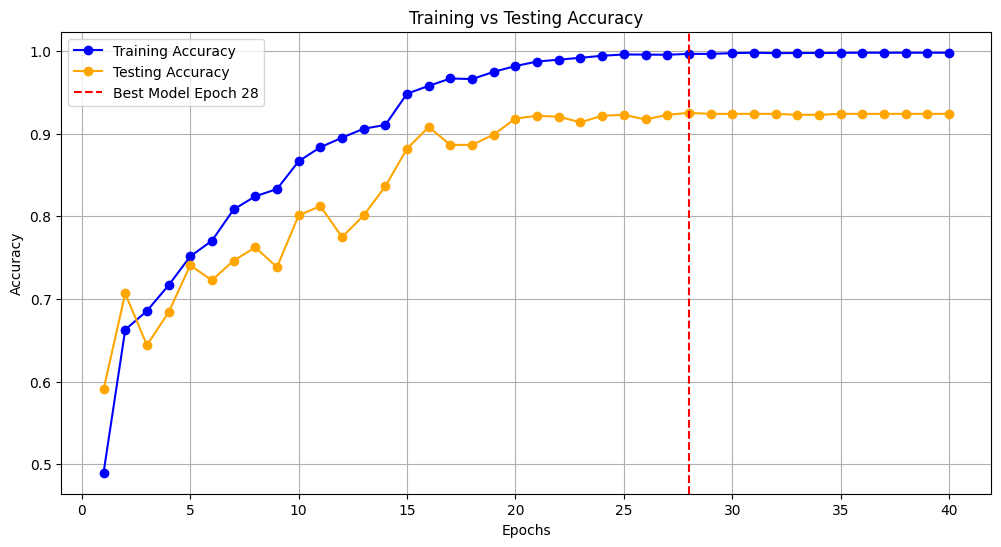

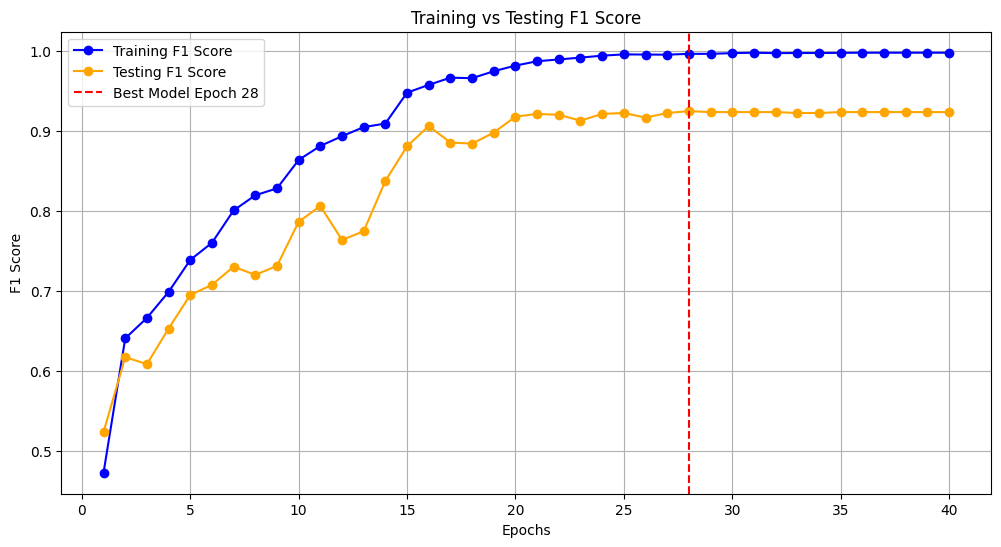

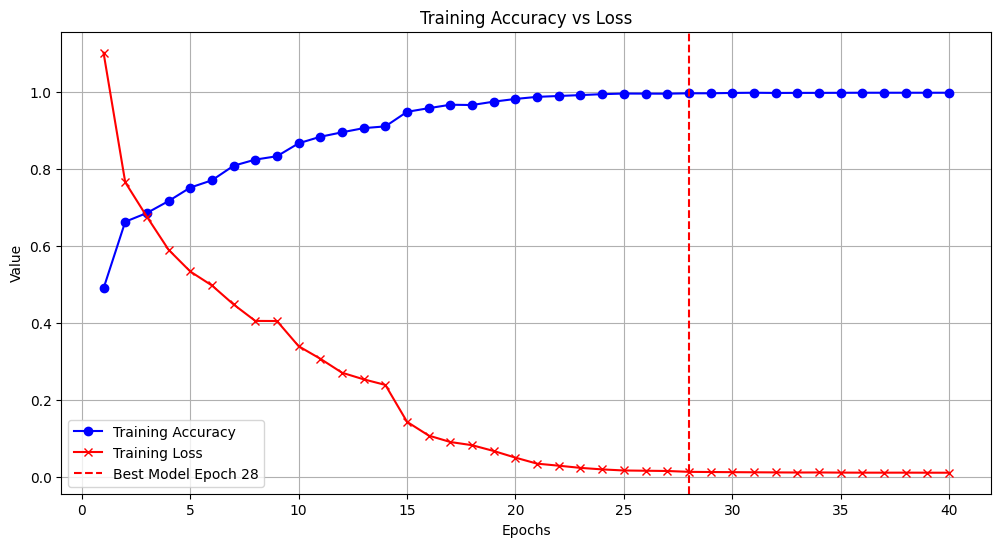

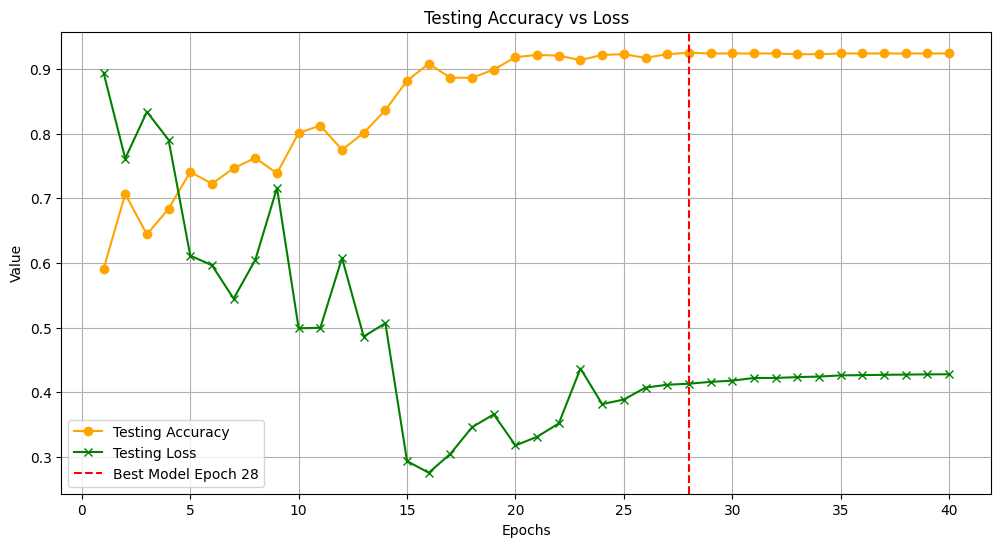

All four plots have been saved and displayed successfully.


In [39]:
# Extracting data for plotting
epochs = [metrics["Epoch"] for metrics in evaluation_list]
train_accuracies = [metrics["Training Accuracy"] for metrics in evaluation_list]
test_accuracies = [metrics["Test Accuracy"] for metrics in evaluation_list]
train_f1_scores = [metrics["Training F1 Score"] for metrics in evaluation_list]
test_f1_scores = [metrics["Test F1 Score"] for metrics in evaluation_list]
train_losses = [metrics["Training Loss"] for metrics in evaluation_list]
test_losses = [metrics["Test Loss"] for metrics in evaluation_list]

# Plotting and saving Training vs Testing Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, test_accuracies, label='Testing Accuracy', color='orange', marker='o')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model Epoch {best_epoch}')  # Add vertical line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_vs_testing_accuracy.png', dpi=300)  # Save with high quality
plt.show()  # Display the plot

# Plotting and saving Training vs Testing F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_f1_scores, label='Training F1 Score', color='blue', marker='o')
plt.plot(epochs, test_f1_scores, label='Testing F1 Score', color='orange', marker='o')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model Epoch {best_epoch}')  # Add vertical line
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training vs Testing F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('training_vs_testing_f1_score.png', dpi=300)  # Save with high quality
plt.show()  # Display the plot

# Plotting and saving Training Accuracy vs Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, train_losses, label='Training Loss', color='red', marker='x')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model Epoch {best_epoch}')  # Add vertical line
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy vs Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy_vs_loss.png', dpi=300)  # Save with high quality
plt.show()  # Display the plot

# Plotting and saving Testing Accuracy vs Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, test_accuracies, label='Testing Accuracy', color='orange', marker='o')
plt.plot(epochs, test_losses, label='Testing Loss', color='green', marker='x')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model Epoch {best_epoch}')  # Add vertical line
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Testing Accuracy vs Loss')
plt.legend()
plt.grid(True)
plt.savefig('testing_accuracy_vs_loss.png', dpi=300)  # Save with high quality
plt.show()  # Display the plot

# Print confirmation
print("All four plots have been saved and displayed successfully.")



In [41]:
# Function to predict class and score from image path
def predict_image(image_path):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image = transform(image).unsqueeze(0).to(device)  # Apply transformation and add batch dimension

    # Perform prediction
    with torch.no_grad():  # No gradient tracking needed for inference
        outputs = best_model(image)  # Forward pass
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get class probabilities
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum output value (predicted class)
        predicted_score = probabilities[0][predicted].item()  # Get the score for the predicted class

    # Map the predicted index to the corresponding class label
    class_names = ['notumor', 'meningioma', 'pituitary', 'glioma']
    predicted_label = class_names[predicted.item()]  # Get the class label

    return predicted_label, predicted_score


In [43]:

# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0006.jpg'  # Replace with the path to your image
predicted_class, predicted_score = predict_image(image_path)
print(f"Predicted class: {predicted_class} | Score: {predicted_score:.4f}")


Predicted class: glioma | Score: 1.0000


In [44]:
print("it's start")

it's start
